# "Medical Cost Analysis: Smoking Is Bad for You (and Your Insurance Charges)"
> "Machine learning workflow to analyze the factor of medical cost for personal insurance using Multiple Linear Regression. Several models are compared by handling outlier, feature selection using step-wise regression (backward and forward), and regularized linear regression (Ridge and Lasso). Four assumptions of linear regression are tested - linearity, normality of residual, homoscedasticity, and no multicollinearity."

- toc: true
- badges: true
- comments: true
- author: Tomy Tjandra
- categories: [python, regression, statsmodels]
- image: images/medical-cost-analysis-rm.jpg

# Introduction
## Business Problem

In this post, we will try to analyze the factor of medical cost for personal insurance (charges) using Multiple Linear Regression. This use case is provided on [Kaggle: Medical Cost Personal Datasets](https://www.kaggle.com/mirichoi0218/insurance) and the dataset is available on [GitHub: Data for Machine Learning with R](https://github.com/stedy/Machine-Learning-with-R-datasets).

## Import Packages
First of all, let's us import packages used in this analysis, mainly for data analysis, visualization, and modeling.

In [1]:
# data analysis
import numpy as np
import pandas as pd

# visualization
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import display, HTML

# modeling
from scipy import stats
from sklearn.model_selection import train_test_split
import statsmodels.api as sm
import sklearn.metrics as metrics
from statsmodels.stats.outliers_influence import variance_inflation_factor

## Set Notebook Options

- Set color of plot to be contrast
- Suppress warning of pandas chaining assignment
- Change float format to three decimal places
- Display all content in a `pandas` column

In [2]:
# collapse-hide
sns.set(style="ticks", color_codes=True)
pd.options.mode.chained_assignment = None
pd.options.display.float_format = '{:.3f}'.format
pd.options.display.max_colwidth = None

# Exploratory Data Analysis (EDA)

Let's us explore to better understand the provided data, by doing data preparation and visualization of the data.

## Data Preparation

Before we jump into further step, we have to make sure our data is ready to be analyze. We import `insurance.csv` and analyze the data structure.

In [3]:
insurance = pd.read_csv("data_input/insurance.csv")
insurance.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.924
1,18,male,33.770,1,no,southeast,1725.552
2,28,male,33.000,3,no,southeast,4449.462
3,33,male,22.705,0,no,northwest,21984.471
4,32,male,28.880,0,no,northwest,3866.855


In [4]:
insurance.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB


`insurance` is a DataFrame object with 1338 rows and 7 columns. There is no missing value present in our data. Here are the explanation for each columns:

- `age`: age of primary beneficiary (in years)
- `sex`: gender of insurance contractor, either female or male
- `bmi`: Body Mass Index which provides an understanding of a body by using a number expressing the ratio of body weight (in kilograms) to height squared (in meters). The value of bmi is ideally between 18.5 and 24.9
- `children`: number of children/dependents covered by health insurance
- `smoker`: whether the primary beneficiary smoking or not
- `region`: the beneficiary's residential area in the US, either northeast, southeast, southwest, or northwest
- `charges`: Individual medical costs billed by health insurance

> Note: We will use `charges` as our target variable and the rest as the candidate predictors.

Based on the explanation above, we have to convert the data type of column `sex`, `smoker`, and `region` into categorical data.

In [5]:
insurance[['sex', 'smoker', 'region']] = insurance[['sex', 'smoker', 'region']].astype('category')
insurance.dtypes

age            int64
sex         category
bmi          float64
children       int64
smoker      category
region      category
charges      float64
dtype: object

We investigate the levels for each categorical data

In [6]:
# collapse-hide
for col in insurance.select_dtypes('category').columns:
    print(f"{col}: {insurance[col].cat.categories.values}")

sex: ['female' 'male']
smoker: ['no' 'yes']
region: ['northeast' 'northwest' 'southeast' 'southwest']


## Visualization

We visualize the numerical variables using pair plot. Plots on the diagonal represent the distribution of each variables, and the rest will be plotted as scatter plot.

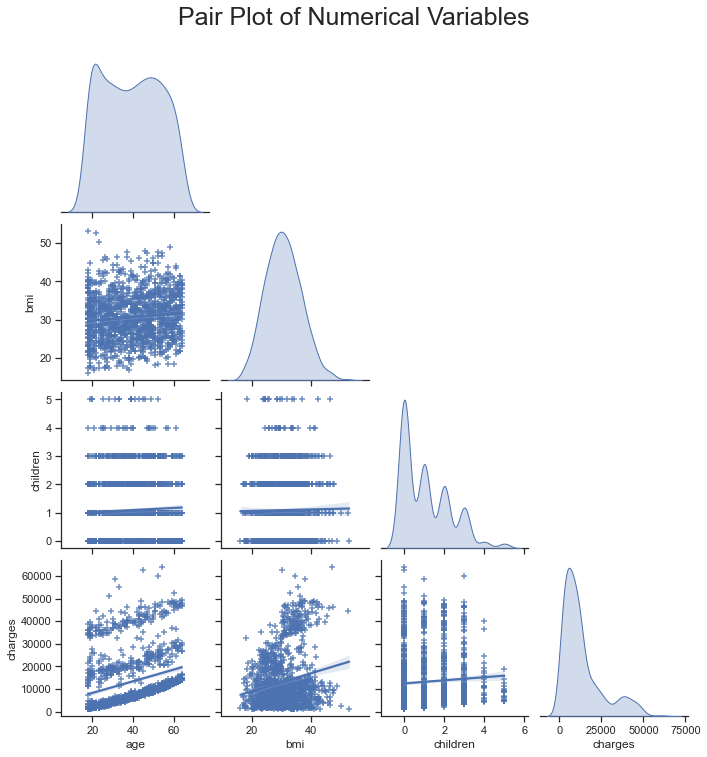

In [7]:
# collapse-hide
pair_plot = sns.pairplot(insurance, diag_kind="kde",
                         corner=True, markers='+', kind="reg")
pair_plot.fig.suptitle("Pair Plot of Numerical Variables", size=25, y=1.05)
pair_plot

From the pair plot above, we couldn't get any interesting insight. How about the categorical variables? Let's us plot them with violin plot, which tell us the distribution of `charges` for categorical variable in each levels.

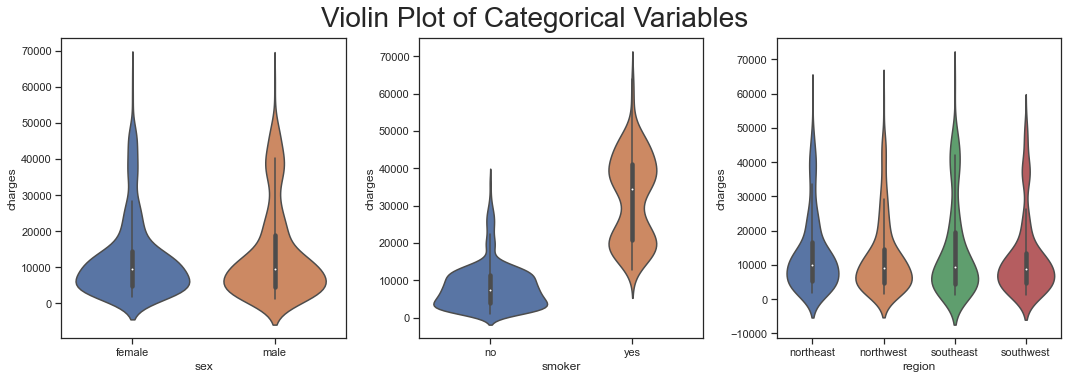

In [8]:
# collapse-hide
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
for ax, col in zip(axes, insurance.select_dtypes('category').columns):
    sns.violinplot(x=col, y="charges", data=insurance, ax=ax)
plt.tight_layout()
fig.suptitle("Violin Plot of Categorical Variables", size=28, y=1.05)

> Note: From the violin plot above, we can clearly see the difference of charges distribution based on `smoker`. The hypothesis is that beneficiary who is a `smoker` will have relatively high `charges` than those who aren't. Is this statistically significant? We will try to analyze this on the modeling section.

To explore the data more, we create scatter plot which represent the distribution of numerical variables based on `charges`, distinguished by each categorical variables.

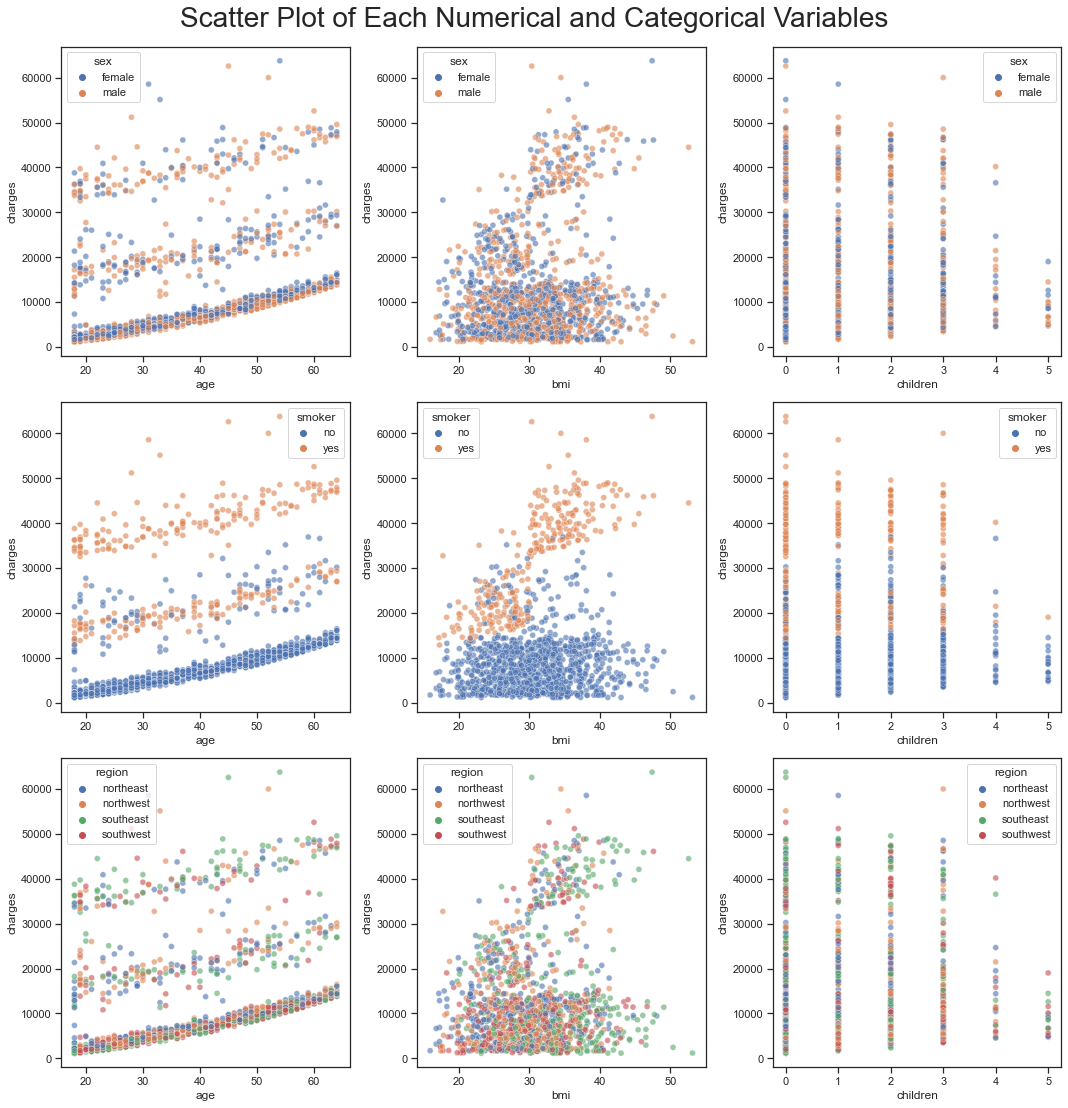

In [9]:
# collapse-hide
fig, axes = plt.subplots(3, 3, figsize=(15, 15))

for row, cat in enumerate(insurance.select_dtypes('category').columns):
    for col, num in enumerate(insurance.select_dtypes(np.number).columns[:-1]):
        sns.scatterplot(x=num, y="charges", hue=cat, data=insurance,
                        alpha=0.6, ax=axes[row][col])

plt.tight_layout()
fig.suptitle(
    "Scatter Plot of Each Numerical and Categorical Variables", size=28, y=1.025)

> Note: Three plots on the second row show us an interesting pattern. Just like the violin plot before, beneficiary who is a `smoker` will relatively have high `charges` no matter the values of `age`, `bmi`, or `children`.

So far, we only focus on the candidate predictors, but how about the distribution of the target variables itself?

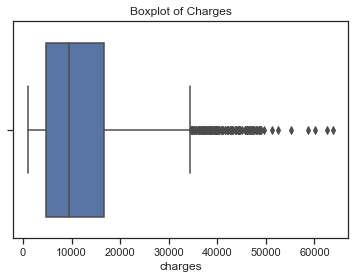

In [10]:
# collapse-hide
y_boxplot = sns.boxplot(x=insurance['charges'])
y_boxplot.set_title("Boxplot of Charges")
y_boxplot;

> Note: The dots which lie outside the whiskers are called as an **outlier**. They are data points which significantly differs from the other observations.

Next, we iteratively remove these outliers from the data and calculate exactly how many data points are considered as an outlier.

Remove Outlier: 139/1338 (10.389%)


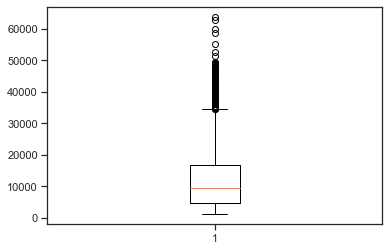

Remove Outlier: 55/1199 (4.587%)


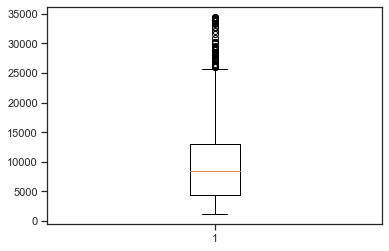

Remove Outlier: 20/1144 (1.748%)


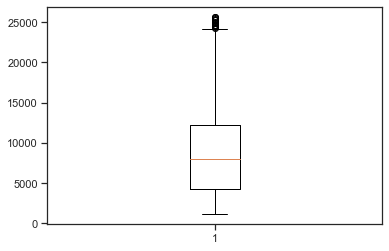

Remove Outlier: 6/1124 (0.534%)


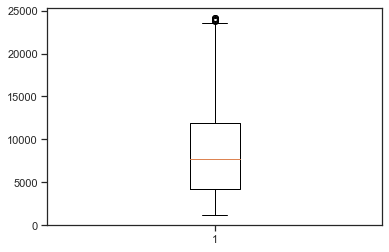

Remove Outlier: 2/1118 (0.179%)


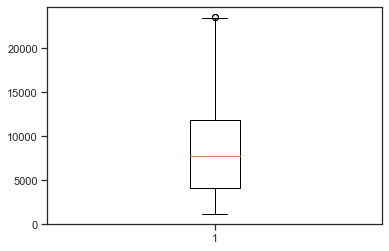

Total Outlier Removed: 222/1338 (16.592%)
Final Range: (1121.8739, 23401.30575)


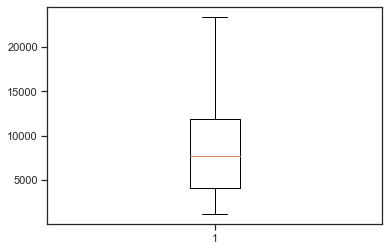

In [11]:
# collapse-hide
insurance_wo_outlier = insurance.copy()
while True:
    y_boxplot = plt.boxplot(insurance_wo_outlier['charges'])
    lower_whisker, upper_whisker = [
        item.get_ydata()[1] for item in y_boxplot['whiskers']]
    outlier_flag = (insurance_wo_outlier['charges'] < lower_whisker) | (
        insurance_wo_outlier['charges'] > upper_whisker)
    num_outlier = sum(outlier_flag)
    if num_outlier == 0:
        before = insurance.shape[0]
        after = insurance_wo_outlier.shape[0]
        print("Total Outlier Removed: {}/{} ({}%)".format(before-after, before,
                                                          round(100*(before-after)/before, 3)))
        print("Final Range: ({}, {})".format(lower_whisker, upper_whisker))

        break
    print("Remove Outlier: {}/{} ({}%)".format(num_outlier, insurance_wo_outlier.shape[0],
                                               round(100*num_outlier/insurance_wo_outlier.shape[0], 3)))
    plt.show()
    insurance_wo_outlier = insurance_wo_outlier[-outlier_flag]

> Warning: Outliers are not meant to always be removed because they may be informative. Thus, we have to try handle it case-by-case. In the next modelling section, we will compare models with and without outliers. Besides removing outliers, one other way is to perform the transformation with the Box-Cox function, but this is not the focus of this post.

## Correlation

In order to apply Linear Regression to our data, we have to check the correlation between each candidate predictors and `charges` as the target variable. Variable will not be a good predictor if it doesn't significantly correlated with the target variable.

Correlation is a statistical measure on how strong a linear relationship between two variables. The values ranged between -1.0 and 1.0, where:
- Positive value = positive correlation, means one variable increases as the other variable increases, or vice versa. The closer to 1, the stronger the positive relationship.
- Negative value = negative correlation, means one variable decreases as the other variable increases, or vice versa. The closer to -1, the stronger the negative relationship.
- Zero = no correlation, means that a variable has nothing to do with the other variable.

Pearson's Correlation Coefficient is one type of correlation which measures the linear relationship between two quantitative variables.

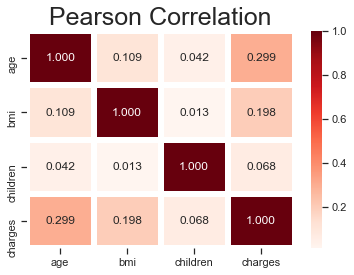

In [12]:
# collapse-hide
corr_heatmap = sns.heatmap(insurance.corr(method="pearson"),
                           annot=True, fmt='.3f', linewidths=5, cmap="Reds")
corr_heatmap.set_title("Pearson Correlation", size=25)
corr_heatmap

> Note: The Pearson correlation between `charges` and the other numerical variables is positively correlated but not very high, means they have a weak linear relationship in the same direction.

## Variable Assumption: Linearity

We also have to perform statistical significancy test to check the linearity of all candidate predictors to our target variable, including the categorical variables. Spearman's rank correlation is a non-parametric test which can be used to measure the degree of association between categorical and numerical variables.

Here is the hypothesis of the test:

- Null Hypothesis ($H_0$): Correlation is not significant
- Alternative Hypothesis ($H_1$): Correlation is significant

In [13]:
# collapse-hide
def check_linearity(data, target_var, SL=0.05):
    cor_test_list = []
    for col in data.drop(target_var, axis=1).columns:
        if col in data.select_dtypes('category').columns:
            cor_test = stats.spearmanr(data[col], data[target_var])
            cor_type = "Spearman"
        else:
            cor_test = stats.pearsonr(data[col], data[target_var])
            cor_type = "Pearson"
        cor_dict = {"Predictor": col,
                    "Type": cor_type,
                    "Correlation": cor_test[0],
                    "P-Value": cor_test[1],
                    "Conclusion": "significant" if cor_test[1] < SL else "not significant"}
        cor_test_list.append(cor_dict)
    return pd.DataFrame(cor_test_list)


check_linearity(insurance, "charges")

,Predictor,Type,Correlation,P-Value,Conclusion
0,age,Pearson,0.299,0.000,significant
1,sex,Spearman,0.009,0.729,not significant
2,bmi,Pearson,0.198,0.000,significant
3,children,Pearson,0.068,0.013,significant
4,smoker,Spearman,0.663,0.000,significant
5,region,Spearman,-0.044,0.111,not significant


> Note: From the correlation test above, we can conclude that `sex` and `region` will not have significant correlation to `charges`. But is this statement also hold if we construct a Linear model from the data? We'll see in the next section.

# Modeling

From previous section, we can summarize:

- Beneficiary who is a `smoker` have relatively high `charges`
- Numerical candidate predictors (`age`, `bmi`, `children`) have positive correlation to `charges`
- `sex` and `region` have no significant correlation to `charges`
- We have to keep in mind about the outliers of `charges`

In this section, we try to construct a linear model to further analyze and interpret the result.

## Data Preparation

We have to do some data preparation specifically for modeling:

- Separate the target variable from the predictors
- Create dummy variables for the categorical predictors
- Train test split in order to evaluate our model, with 80% train and 20% test

In [14]:
# split predictor and target
X_raw = insurance.drop(["charges"], axis=1)
y = insurance.charges.values

# dummy variables
X = pd.get_dummies(X_raw,
                   columns=insurance.select_dtypes('category').columns,
                   drop_first=True)

# train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=333)
print("X Train:", X_train.shape)
print("X Test:", X_test.shape)
print("y Train:", y_train.shape)
print("y Test:", y_test.shape)


X Train: (1070, 8)
X Test: (268, 8)
y Train: (1070,)
y Test: (268,)


## Linear model with all predictors

This is the equation of Multiple Linear Regression that we have to estimate:
$\hat{Y} = \beta_0 + \beta_1 X_1 + \beta_2 X_2 + ... + \beta_n X_n$
where:
- $\hat{Y}$ is the predicted value of target variable
- $X_1, X_2, ..., X_n$ are the predictors
- $\beta_0$ is the intercept / constant
- $\beta_1, \beta_2, ..., \beta_n$ are the slope of respective predictors $X_1, X_2, ..., X_n$
- $n$ is the number of predictors

As a starting point, let's us fit a linear model with all existing predictors and see how it goes.

In [15]:
model_all = sm.OLS(y_train, sm.add_constant(X_train))
result_all = model_all.fit()
print(result_all.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.740
Model:                            OLS   Adj. R-squared:                  0.738
Method:                 Least Squares   F-statistic:                     378.2
Date:                Thu, 21 Oct 2021   Prob (F-statistic):          2.00e-304
Time:                        00:42:30   Log-Likelihood:                -10846.
No. Observations:                1070   AIC:                         2.171e+04
Df Residuals:                    1061   BIC:                         2.175e+04
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const            -1.224e+04   1112.140  

Wow, there's a lot of information and numbers! Here are some important terms:
***
Top Section
***
- **R-squared** tells about the goodness of the fit, ranges between 0 and 1. The closer the value to 1, the better it explains the dependent variables variation in the model. However, it is biased in a way that it never decreases when we add new variables.
- **Adj. R-squared** has a penalising factor. It decreases or stays identical to the previous value as the number of predictors increases. If the value keeps increasing on removing the unnecessary parameters go ahead with the model or stop and revert.
- **F-statistic** used to compare two variances and the value is always greater than 0. In regression, it is the ratio of the explained to the unexplained variance of the model.
- **AIC** stands for Akaike’s information criterion. It estimates the relative amount of information lost by a given model. The lower the AIC, the higher the quality of that model.

***
Mid Section
***
- **coef** is the coefficient/estimate value of intercept and slope.
- **$P>|t|$** refers to the p-value of partial tests with the null hypothesis $H_0$ that the coefficient is equal to zero (no effect). A low p-value (< 0.05) indicates that the predictor has significant effect to the target variable.

***
Bottom Section
***
- **Omnibus** - D'Angostino's test. It provides a combined statistical test for the presence of skewness and kurtosis.
- **Skew** informs about the data symmetry about the mean.
- **Kurtosis** measures the shape of the distribution (i.e. the amount of data close to the mean than far away from the mean).

> Note: From the summary result above, we can conclude that the performance of model is moderate (Adj. R-squared of 73.8%) and there are two insignificant predictors (`sex` and `region`), which align with the statement on Exploratory Data Analysis section.

## Feature Selection

How we can further improve our model? One way is by feature selection using step-wise regression, specifically backward elimination and forward selection. On each step, we remove/select the predictors which results a **smaller AIC**. Besides that, we also have to really consider the business case also. This plays a role in making decision about which predictors are going to be used in our model.

### Backward Elimination

In [16]:
# collapse-hide
def backwardEliminationByAIC(X, y, show_iter=True):
    X_step = X.copy()
    num_iter = 1
    drop_list = []
    while True:
        res_list = []
        for col in ['none'] + list(X_step.columns):
            X_curr = X_step.drop(col, axis=1) if col != "none" else X_step
            model = sm.OLS(y, sm.add_constant(X_curr)).fit()
            res_list.append({"drop": col, "aic": model.aic})

        curr_res = pd.DataFrame(res_list).sort_values("aic")
        col_to_be_removed = list(curr_res["drop"])[0]

        if show_iter:
            print("Iteration {}: Drop {}".format(num_iter, col_to_be_removed))
            display(HTML(curr_res.to_html(index=False)))

        if col_to_be_removed == "none":
            break
        else:
            drop_list.append(col_to_be_removed)
            X_step = X_step.drop(col_to_be_removed, axis=1)
        num_iter += 1
    X_back = X.drop(drop_list, axis=1)
    model_back = sm.OLS(y, sm.add_constant(X_back))
    return model_back


model_back = backwardEliminationByAIC(X, y)
predictor_back = model_back.exog_names[1:]
predictor_back

Iteration 1: Drop sex_male


drop,aic
sex_male,27111.662
region_northwest,27112.059
none,27113.506
region_southwest,27115.562
region_southeast,27116.204
children,27123.439
bmi,27246.117
age,27513.667
smoker_yes,28790.423


Iteration 2: Drop region_northwest


drop,aic
region_northwest,27110.213
none,27111.662
region_southwest,27113.713
region_southeast,27114.354
children,27121.551
bmi,27244.141
age,27512.317
smoker_yes,28792.896


Iteration 3: Drop none


drop,aic
none,27110.213
region_southwest,27111.806
region_southeast,27112.503
children,27119.957
bmi,27242.621
age,27510.818
smoker_yes,28792.253


['age',
 'bmi',
 'children',
 'smoker_yes',
 'region_southeast',
 'region_southwest']

> Note: The predictors that backward elimination method recommends are `age`, `bmi`, `children`, `smoker_yes`, `region_southeast`, `region_southwest`

### Forward Selection

In [17]:
# collapse-hide
def forwardSelectionByAIC(X, y, show_iter=True):
    X_step = pd.DataFrame(sm.add_constant(X)['const'])
    num_iter = 1
    add_list = []

    while True:
        res_list = [{"add": "none", "aic": sm.OLS(
            y, sm.add_constant(X_step)).fit().aic}]
        for col in list(set(X.columns) - set(add_list)):
            X_curr = X[add_list + [col]]
            model = sm.OLS(y, sm.add_constant(X_curr)).fit()
            res_list.append({"add": col, "aic": model.aic})

        curr_res = pd.DataFrame(res_list).sort_values("aic")
        col_to_be_added = list(curr_res["add"])[0]

        if show_iter:
            print("Iteration {}: Add {}".format(num_iter, col_to_be_added))
            display(HTML(curr_res.to_html(index=False)))

        if col_to_be_added == "none":
            break
        else:
            add_list.append(col_to_be_added)
            X_step = X[add_list]
        num_iter += 1
    X_forward = X[add_list]
    model_forward = sm.OLS(y, sm.add_constant(X_forward))
    return model_forward


model_forward = forwardSelectionByAIC(X, y)
predictor_forward = model_forward.exog_names[1:]
predictor_forward

Iteration 1: Add smoker_yes


add,aic
smoker_yes,27665.464
age,28833.949
bmi,28905.564
region_southeast,28951.920
children,28953.062
sex_male,28954.864
region_southwest,28956.763
region_northwest,28957.131
none,28957.263


Iteration 2: Add age


add,aic
age,27251.324
bmi,27525.890
children,27653.886
none,27665.464
region_southeast,27666.041
region_southwest,27666.760
region_northwest,27667.051
sex_male,27667.438


Iteration 3: Add bmi


add,aic
bmi,27121.836
children,27242.027
region_southeast,27250.719
none,27251.324
region_southwest,27251.930
region_northwest,27252.805
sex_male,27253.270


Iteration 4: Add children


add,aic
children,27112.035
region_southeast,27121.349
none,27121.836
region_southwest,27122.498
region_northwest,27123.102
sex_male,27123.729


Iteration 5: Add region_southeast


add,aic
region_southeast,27111.806
none,27112.035
region_southwest,27112.503
region_northwest,27113.443
sex_male,27113.886


Iteration 6: Add region_southwest


add,aic
region_southwest,27110.213
none,27111.806
sex_male,27113.655
region_northwest,27113.713


Iteration 7: Add none


add,aic
none,27110.213
region_northwest,27111.662
sex_male,27112.059


['smoker_yes',
 'age',
 'bmi',
 'children',
 'region_southeast',
 'region_southwest']

In [18]:
set(predictor_back) == set(predictor_forward)

True

> Note: The predictors that forward selection method recommends are just the **same** as backward selection recommends: `age`, `bmi`, `children`, `smoker_yes`, `region_southeast`, `region_southwest`

### Business Case

When building a model, we have to take into consideration about the business perspective also. According to [healthcare.gov](https://www.healthcare.gov/how-plans-set-your-premiums/), five factors that can affect a plan’s premium are location, age, tobacco use, plan category, and whether the plan covers dependents. Insurance companies can’t charge women and men different prices for the same plan.

> Note: In conclusion, based on the step-wise regression and business case, we should have the following predictors: `age`, `bmi`, `children`, `smoker`, `region`.

## Model Comparison

In this section, we are going to compare the following models:
1. Model with all predictors
2. Model without predictor `sex`
3. Model without predictor `sex` and `region`
4. All of the above models with outlier removed

We define the function `experimentModel()` to compare these models later.

In [19]:
def experimentModel(X_train, X_test, y_train, ignore_var=[]):
    X_train_new = X_train.drop(ignore_var, axis=1)
    X_test_new = X_test.drop(ignore_var, axis=1)
    model_new = sm.OLS(y_train, sm.add_constant(X_train_new))
    result_new = model_new.fit()
    return X_test_new, result_new

### Second and Third Model

In [20]:
# 2. Model without predictor sex
X_test_wo_sex, result_wo_sex = \
    experimentModel(X_train, X_test, y_train, ignore_var=['sex_male'])

# 3. Model without predictor sex and region
X_test_wo_sex_region, result_wo_sex_region = \
    experimentModel(X_train, X_test, y_train, ignore_var=[
                    'sex_male', 'region_northwest', 'region_southeast', 'region_southwest'])

### Models without Outliers

Recall that 16.592% of our target variable are outliers. Next, we try to build the same three models above with the outliers being removed:
1. Model with all predictors
2. Model without predictor `sex`
3. Model without predictor `sex` and `region`

In [21]:
# collapse-hide
X_wo_outlier = X.iloc[insurance_wo_outlier.index]
y_wo_outlier = insurance_wo_outlier.charges.values
X_train_wo_outlier, X_test_wo_outlier, y_train_wo_outlier, y_test_wo_outlier = train_test_split(
    X_wo_outlier, y_wo_outlier, test_size=0.2, random_state=333)
print("X Train:", X_train_wo_outlier.shape)
print("X Test:", X_test_wo_outlier.shape)
print("y Train:", y_train_wo_outlier.shape)
print("y Test:", y_test_wo_outlier.shape)

X Train: (892, 8)
X Test: (224, 8)
y Train: (892,)
y Test: (224,)


In [22]:
X_test_wo_outlier_all, result_wo_outlier_all = \
    experimentModel(X_train_wo_outlier, X_test_wo_outlier, y_train_wo_outlier)

X_test_wo_outlier_wo_sex, result_wo_outlier_wo_sex = \
    experimentModel(X_train_wo_outlier, X_test_wo_outlier,
                    y_train_wo_outlier, ignore_var=['sex_male'])

X_test_wo_outlier_wo_sex_region, result_wo_outlier_wo_sex_region = \
    experimentModel(X_train_wo_outlier, X_test_wo_outlier, y_train_wo_outlier, ignore_var=[
                    'sex_male', 'region_northwest', 'region_southeast', 'region_southwest'])

### Evaluation

In order to choose the best model, we are going to consider several metrics:

- R-squared, the higher the better
- Adjusted R-squared, the higher the better
- Root Mean Squared Error (RMSE), the lower the better
- Mean Absolute Percentage Error (MAPE), the lower the better

In [23]:
# collapse-hide
def evalRegression(model, X_true, y_true, outlier=True, decimal=5):
    y_pred = model.predict(sm.add_constant(X_true))

    metric = {
        "Predictor": sorted(model.model.exog_names[1:]),
        "Outlier": "Included" if outlier else "Excluded",
        "R-sq": round(model.rsquared, decimal),
        "Adj. R-sq": round(model.rsquared_adj, decimal),
        "RMSE": round(np.sqrt(metrics.mean_squared_error(y_true, y_pred)), decimal),
        "MAPE": round(np.mean(np.abs((y_true - y_pred) / y_true)) * 100, decimal)
    }

    return metric

In [24]:
# collapse-hide
eval_df = pd.DataFrame([
    evalRegression(result_all, X_test, y_test),
    evalRegression(result_wo_sex, X_test_wo_sex, y_test),
    evalRegression(result_wo_sex_region, X_test_wo_sex_region, y_test),
    evalRegression(result_wo_outlier_all, X_test_wo_outlier_all,
                   y_test_wo_outlier, outlier=False),
    evalRegression(result_wo_outlier_wo_sex,
                   X_test_wo_outlier_wo_sex, y_test_wo_outlier, outlier=False),
    evalRegression(result_wo_outlier_wo_sex_region, X_test_wo_outlier_wo_sex_region, y_test_wo_outlier, outlier=False)],
    index=range(1, 7))
eval_df.index.name = "Model"
eval_df

,Predictor,Outlier,R-sq,Adj. R-sq,RMSE,MAPE
Model,,,,,,
1,"[age, bmi, children, region_northwest, region_southeast, region_southwest, sex_male, smoker_yes]",Included,0.740,0.738,5790.481,40.135
2,"[age, bmi, children, region_northwest, region_southeast, region_southwest, smoker_yes]",Included,0.740,0.739,5787.291,39.909
3,"[age, bmi, children, smoker_yes]",Included,0.739,0.738,5797.358,40.540
4,"[age, bmi, children, region_northwest, region_southeast, region_southwest, sex_male, smoker_yes]",Excluded,0.683,0.680,2582.015,21.894
5,"[age, bmi, children, region_northwest, region_southeast, region_southwest, smoker_yes]",Excluded,0.682,0.679,2592.232,21.893
6,"[age, bmi, children, smoker_yes]",Excluded,0.677,0.675,2602.342,22.538


We are going to select the best model out of the six models, here are the thought process:
1. Compare the first three models (with outlier) with the last three models (without outlier). We can see that models with outlier have better R-squared and Adjusted R-squared, but worst in terms of error. In this case, we prefer models **without outlier**, since the drop of MAPE is quite significant.
2. Out of the three models without outlier, the model with all predictors has the highest Adj. R-sq and the lowest RMSE. But according to the statistical test and business case, we should remove `sex` predictor. On the other hand, `region` must be included due to the business case even though it is not significant statistically. So, in this case we choose **model 5**, having the lowest MAPE.

In [25]:
# model 5
final_X_test = X_test_wo_outlier_wo_sex
final_y_test = y_test_wo_outlier
final_result = result_wo_outlier_wo_sex

## Regularized Linear Regression

Here, we try to improve the **model 5** performance by using regularized linear regression. There are two simple techniques to reduce model complexity and prevent overfitting:
1. Ridge Regression, the cost function is added by a penalty weight equivalent to the square of the coefficients. This shrinks the coefficients and helps to reduce the model complexity and multicollinearity.
2. Lasso (Least Absolute Shrinkage and Selection Operator) Regression, which helps reducing overfitting and also used as feature selection.

In [26]:
# collapse-hide
def evalRegularizedRegression(model_result, X_test, y_test):
    model = model_result.model
    eval_regularized_list = []
    for alpha in np.linspace(0, 10, 101):
        for fit_type in [0, 1]:
            result_regularized = model.fit_regularized(alpha=round(alpha, 2),
                                                       L1_wt=fit_type,
                                                       start_params=model_result.params)
            final = sm.regression.linear_model.OLSResults(model,
                                                          result_regularized.params,
                                                          model.normalized_cov_params)
            metric = {}
            metric["alpha"] = alpha
            metric["Fit Type"] = "Ridge" if fit_type == 0 else "Lasso"
            metric.update(evalRegression(final, X_test, y_test, outlier=False))
            metric.pop("Predictor")

            eval_regularized_list.append(metric)
    return pd.DataFrame(eval_regularized_list)

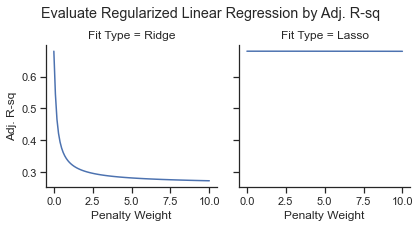

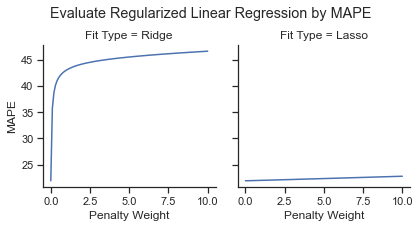

In [27]:
# collapse-hide
eval_regularized = evalRegularizedRegression(
    final_result, final_X_test, final_y_test)

for metric in ["Adj. R-sq", "MAPE"]:
    facet = sns.FacetGrid(eval_regularized, col="Fit Type")
    facet = facet.map(plt.plot, "alpha", metric)
    facet.set_axis_labels("Penalty Weight")
    facet.fig.suptitle(
        "Evaluate Regularized Linear Regression by {}".format(metric), y=1.05)

Display `alpha` of Ridge and Lasso regression with maximum Adj. R-squared and minimum MAPE:

In [28]:
# collapse-hide
eval_regularized[(eval_regularized["Adj. R-sq"] == max(eval_regularized["Adj. R-sq"])) &
                 (eval_regularized["MAPE"] == min(eval_regularized["MAPE"]))]

,alpha,Fit Type,Outlier,R-sq,Adj. R-sq,RMSE,MAPE
0,0.000,Ridge,Excluded,0.682,0.679,2592.232,21.893
1,0.000,Lasso,Excluded,0.682,0.679,2592.232,21.893


> Note: Based on the result, it recommends us to penalize the parameters using $\alpha = 0$ which means no regularization is needed. Unfortunately, we couldn't improve the model performance by this technique. So we stick with the previous **model 5**.

# Model Interpretation

Here is our final model:

In [29]:
print(final_result.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.682
Model:                            OLS   Adj. R-squared:                  0.679
Method:                 Least Squares   F-statistic:                     270.6
Date:                Thu, 21 Oct 2021   Prob (F-statistic):          7.44e-215
Time:                        00:42:45   Log-Likelihood:                -8426.1
No. Observations:                 892   AIC:                         1.687e+04
Df Residuals:                     884   BIC:                         1.691e+04
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const            -2242.1832    615.674  

In [30]:
print(final_result.params)

const              -2242.183
age                  234.311
bmi                   33.828
children             391.309
smoker_yes         12785.840
region_northwest    -601.538
region_southeast   -1059.610
region_southwest    -873.367
dtype: float64


We can interpret the coefficient of model summary as follows:

- One unit increase in `age`, `bmi`, and `children` will increase insurance `charges` by 234.3, 33.8, 391.3 respectively
- Being a `smoker` will cost 12785.84 more `charges` than those who aren't (what a significant increase!)
- If two beneficiaries have the same `age`, `bmi`, `children`, and `smoker`, then people who are living in southeast will have the smallest `charges` than other `region`. On the other hand, people who are living in northeast will have the largest `charges`.

# Check Model Assumptions

The linear regression model is the most rigid model among others. Several assumptions must be met in order to satisfy the best linear unbiased estimator (BLUE).

## Normality of Residual

The residuals have to distribute around mean 0 and some variance, which follows a **standard normal distribution**. We plot a histogram to visualize the distribution of the residuals.

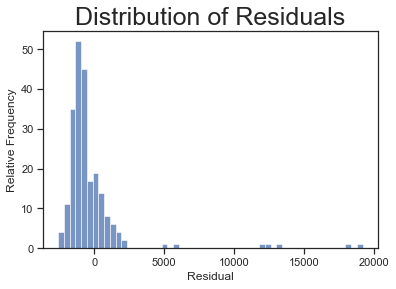

In [31]:
# collapse-hide
def plotResidualNormality(residual):
    residual_histogram = sns.histplot(residual)
    residual_histogram.set_xlabel("Residual")
    residual_histogram.set_ylabel("Relative Frequency")
    residual_histogram.set_title("Distribution of Residuals", size=25)
    return residual_histogram


y_pred = final_result.predict(sm.add_constant(final_X_test))
residual = final_y_test - y_pred
plotResidualNormality(residual)

Another way is to statistically test the normality using **Shapiro-Wilk** test.

- Null Hypothesis ($H_0$): Residuals are normally distributed
- Alternative Hypothesis ($H_1$): Residuals are not normally distributed

In [32]:
# collapse-hide
def statResidualNormality(residual):
    W, pvalue = stats.shapiro(residual)
    print("Shapiro-Wilk Normality Test")
    print("W: {}, p-value: {}".format(W, pvalue))
    
statResidualNormality(residual)

Shapiro-Wilk Normality Test
W: 0.4523528814315796, p-value: 1.0307846384403909e-25


> Note: From Shapiro-Wilk Normality Test, we reject the null hypothesis since the p-value < 0.05 and conclude that the residuals are not normally distributed. Thus, assumption is not passed.

## Homoscedasticity

The residuals have to distributed homogeneously which means residuals has a constant variance and doesn't form any pattern. We can visualize it using a scatter plot.

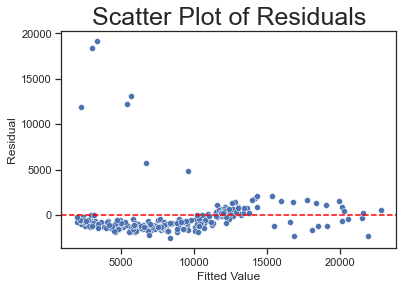

In [33]:
# collapse-hide
def plotResidualHomoscedasticity(y_true, y_pred):
    residual = y_true - y_pred
    residual_scatter = sns.scatterplot(x=y_pred, y=residual)
    residual_scatter.axhline(0, ls='--', c="red")
    residual_scatter.set_xlabel("Fitted Value")
    residual_scatter.set_ylabel("Residual")
    residual_scatter.set_title("Scatter Plot of Residuals", size=25)
    return residual_scatter

plotResidualHomoscedasticity(final_y_test, y_pred)

Another way is to statistically test the homoscedasticity using **Breusch-Pagan** test.

- Null Hypothesis ($H_0$): Variation of residual is constant (Homoscedasticity)
- Alternative Hypothesis ($H_1$): Variation of residual is not constant (Heteroscedasticity)

In [34]:
# collapse-hide
def statResidualHomoscedasticity(X, residual):
    lm, lm_pvalue, fvalue, f_pvalue = sm.stats.diagnostic.het_breuschpagan(
        residual, np.array(sm.add_constant(X)))

    print("Studentized Breusch-Pagan Test")
    print("Lagrange Multiplier: {}, p-value: {}".format(lm, lm_pvalue))
    print("F: {}, p-value: {}".format(fvalue, f_pvalue))


statResidualHomoscedasticity(final_X_test, residual)

Studentized Breusch-Pagan Test
Lagrange Multiplier: 10.58590985799841, p-value: 0.1577290355280313
F: 1.5305968436467638, p-value: 0.15816141333372216


> Note: From Studentized Breusch-Pagan Test, we fail to reject the null hypothesis since the p-value > 0.05 and conclude that variation of residual is constant (Homoscedasticity). Thus, assumption is passed.

## No Multicollinearity

Multicollinearity is a condition where at least two predictors have a strong linear relationship. We expect the model to have little to no multicollinearity. It exists if the **Variance Inflation Factor (VIF)** value is greater than 10.

In [35]:
# collapse-hide
vif_list = []
for idx, col in enumerate(final_result.model.exog_names[1:]):
    vif_dict = {"Variable": col,
                "VIF": variance_inflation_factor(final_result.model.exog, idx+1)}
    vif_list.append(vif_dict)

pd.DataFrame(vif_list)

,Variable,VIF
0,age,1.039
1,bmi,1.183
2,children,1.003
3,smoker_yes,1.090
4,region_northwest,1.499
5,region_southeast,1.624
6,region_southwest,1.541


> Note: From VIF value, we can conclude that there is only little multicollinearity exist in our model. Thus, assumption is passed.

# Conclusions

Linear regression is a highly interpretable model, meaning we can understand and account the predictors that are being included and excluded from the model. From the model summary, we know that being a `smoker` will cause a significant increase in beneficiary's `charges` than those who aren't.

In the end, we choose the model which excludes the outlier data since it gives us a better prediction (lower error performance, but the trade-off is a lower Adjusted R-squared. Using regularization worsen the overall model performance.

The normality of residual assumption is not fulfilled. This can be handled by several ways:

- Try to transform the target variable using Box-Cox (logarithm or square-root function) transformation.
- If we only focus on building a robust model without interpretation, then we can try ensemble methods to prevent rigid model assumptions, such as Random Forest Regressor.